# Australia Plauge Locust Modeling

This section covers the spatial modeling for australian plague locusts

- section 1: data management
- section 2: outbreak modeling
- section 3: nil-observatiom modeling
- section 4: outbreak and mean annual preciptation modeling

We will do basic modeling and saving relevant data to disk 

Another notebook later in the series will create mansucript figures and tables

# Section 1 - Data management

In [1]:
load_packages <- function(packages) {
  # Check for uninstalled packages
  uninstalled <- packages[!packages %in% installed.packages()[,"Package"]]
  
  # Install uninstalled packages
  if(length(uninstalled)) install.packages(uninstalled, dependencies = TRUE)

  # Load all packages
  for (pkg in packages) {
    if (!require(pkg, character.only = TRUE, quietly = TRUE)) {
      message(paste("Failed to load package:", pkg))
    }
  }
}

# List of packages to check, install, and load
packages <- c("mgcv", "gratia", "sf","rnaturalearth",
              "ggpubr", "patchwork", "broom", "knitr", "janitor", 
              "here","ggpubr","MetBrewer","GGally","tidyverse")

load_packages(packages)

i_am('README.md')


# Setting R options for jupyterlab
options(repr.plot.width = 10, repr.plot.height = 10,repr.matrix.max.rows=10)


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 8.2.1; sf_use_s2() is TRUE


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


here() starts at /home/datascience/nutrients_and_locust_outbreaks/scripts/spatial_modeling

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ stringr::boundary() masks gratia::boundary()
✖ dplyr::collapse()   masks nlme::collapse()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all con

## read in data

- filter species for APL
- manage data into long format
- select variables used for modeling
- create outbreak and nil observation datasets

In [2]:
apl_dat <- read_csv(here('data/processed/spatial_modeling/apl_survey_remote_sense_data.csv'),show_col_types = FALSE)

In [3]:
apl_locust_dat <- apl_dat |>
    clean_names() |>
  mutate(adult_density = str_remove_all(adult_density, "[{}]"),
         nymph_density = str_remove_all(nymph_density, "[{}]")) %>%
  separate_rows(adult_density, sep = ", ") %>%
  separate(adult_density, into = c("adult_density", "adult_density_count"), sep = ": ") %>%
  separate_rows(nymph_density, sep = ", ") %>%
  separate(nymph_density, into = c("nymph_density", "nymph_density_count"), sep = ": ") %>%
  mutate(across(c(adult_density, adult_density_count, nymph_density, nymph_density_count), as.numeric)) |> 
  distinct() |>
  group_by(polygon_id,species) |>
  mutate(total_observations = n()) 


In [4]:
apl_outbreak_dat <- apl_locust_dat |>
    ungroup() |>
    filter(species == 11 & nymph_density == 4) |>
    select(polygon_id,longitude,latitude,nymph_density,nymph_density_count,nymph_density_total_count,
           nto_nto_000_005_ev,nto_nto_005_015_ev,pto_pto_005_015_ev,pto_pto_000_005_ev) |>
    group_by(polygon_id) |>
    mutate(nitrogen = sum(nto_nto_005_015_ev,nto_nto_000_005_ev)/2, 
           phosphorus = sum(pto_pto_005_015_ev,pto_pto_000_005_ev)/2) |>
    select(!c(nto_nto_000_005_ev,nto_nto_005_015_ev,pto_pto_005_015_ev,pto_pto_000_005_ev))  |>
    distinct()

apl_nil_dat <- apl_locust_dat |>
    ungroup() |>
    filter(species == 11 & nymph_density == 0) |>
    select(polygon_id,longitude,latitude,nymph_density,nymph_density_count,nymph_density_total_count,
           nto_nto_000_005_ev,nto_nto_005_015_ev,pto_pto_005_015_ev,pto_pto_000_005_ev) |>
    group_by(polygon_id) |>
    mutate(nitrogen = sum(nto_nto_005_015_ev,nto_nto_000_005_ev)/2, 
           phosphorus = sum(pto_pto_005_015_ev,pto_pto_000_005_ev)/2) |>
    select(!c(nto_nto_000_005_ev,nto_nto_005_015_ev,pto_pto_005_015_ev,pto_pto_000_005_ev)) |>
    distinct()

### save to disk for further use

In [5]:

write.csv(apl_outbreak_dat,here('data/processed/spatial_modeling/spatial_modeling_locust_outbreak_model_data.csv'),row.names=FALSE)

write.csv(apl_nil_dat,here('data/processed/spatial_modeling/spatial_modeling_locust_nil_model_data.csv.csv'),row.names=FALSE)


# Section 2 - outbreak modeling

In [6]:
outbreak_data <- read_csv(here('data/processed/spatial_modeling/spatial_modeling_locust_outbreak_model_data.csv'),
                          show_col_types = FALSE)

In [7]:
summary(outbreak_data)

   polygon_id        longitude        latitude      nymph_density
 Min.   : 162921   Min.   :137.0   Min.   :-37.57   Min.   :4    
 1st Qu.: 437652   1st Qu.:139.7   1st Qu.:-34.45   1st Qu.:4    
 Median :1009080   Median :143.0   Median :-32.53   Median :4    
 Mean   : 984239   Mean   :142.9   Mean   :-32.25   Mean   :4    
 3rd Qu.:1494166   3rd Qu.:146.0   3rd Qu.:-31.04   3rd Qu.:4    
 Max.   :2092645   Max.   :151.3   Max.   :-21.08   Max.   :4    
 nymph_density_count nymph_density_total_count    nitrogen      
 Min.   : 1.000      Min.   : 1.000            Min.   :0.02707  
 1st Qu.: 1.000      1st Qu.: 1.000            1st Qu.:0.05679  
 Median : 1.000      Median : 1.000            Median :0.07959  
 Mean   : 1.422      Mean   : 2.267            Mean   :0.09497  
 3rd Qu.: 1.000      3rd Qu.: 3.000            3rd Qu.:0.11589  
 Max.   :23.000      Max.   :37.000            Max.   :0.61003  
   phosphorus     
 Min.   :0.01107  
 1st Qu.:0.02563  
 Median :0.03098  
 Mean  

## Raw data visualization

In [8]:
head(outbreak_data,1)
nrow(outbreak_data)

polygon_id,longitude,latitude,nymph_density,nymph_density_count,nymph_density_total_count,nitrogen,phosphorus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
162921,137.1195,-33.36002,4,1,1,0.07035461,0.02197414


[1] 6659

In [9]:
aus <- ne_states(country = 'Australia')


map_dat <- outbreak_data |>
    select(polygon_id,latitude,longitude,nymph_density_count) |>
    st_as_sf(coords = c('longitude','latitude'),
                   crs= "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")

outbreak_point_map <- aus |>
    ggplot() +
        geom_sf() +
        geom_sf(data=map_dat) +
        theme_void() 



`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


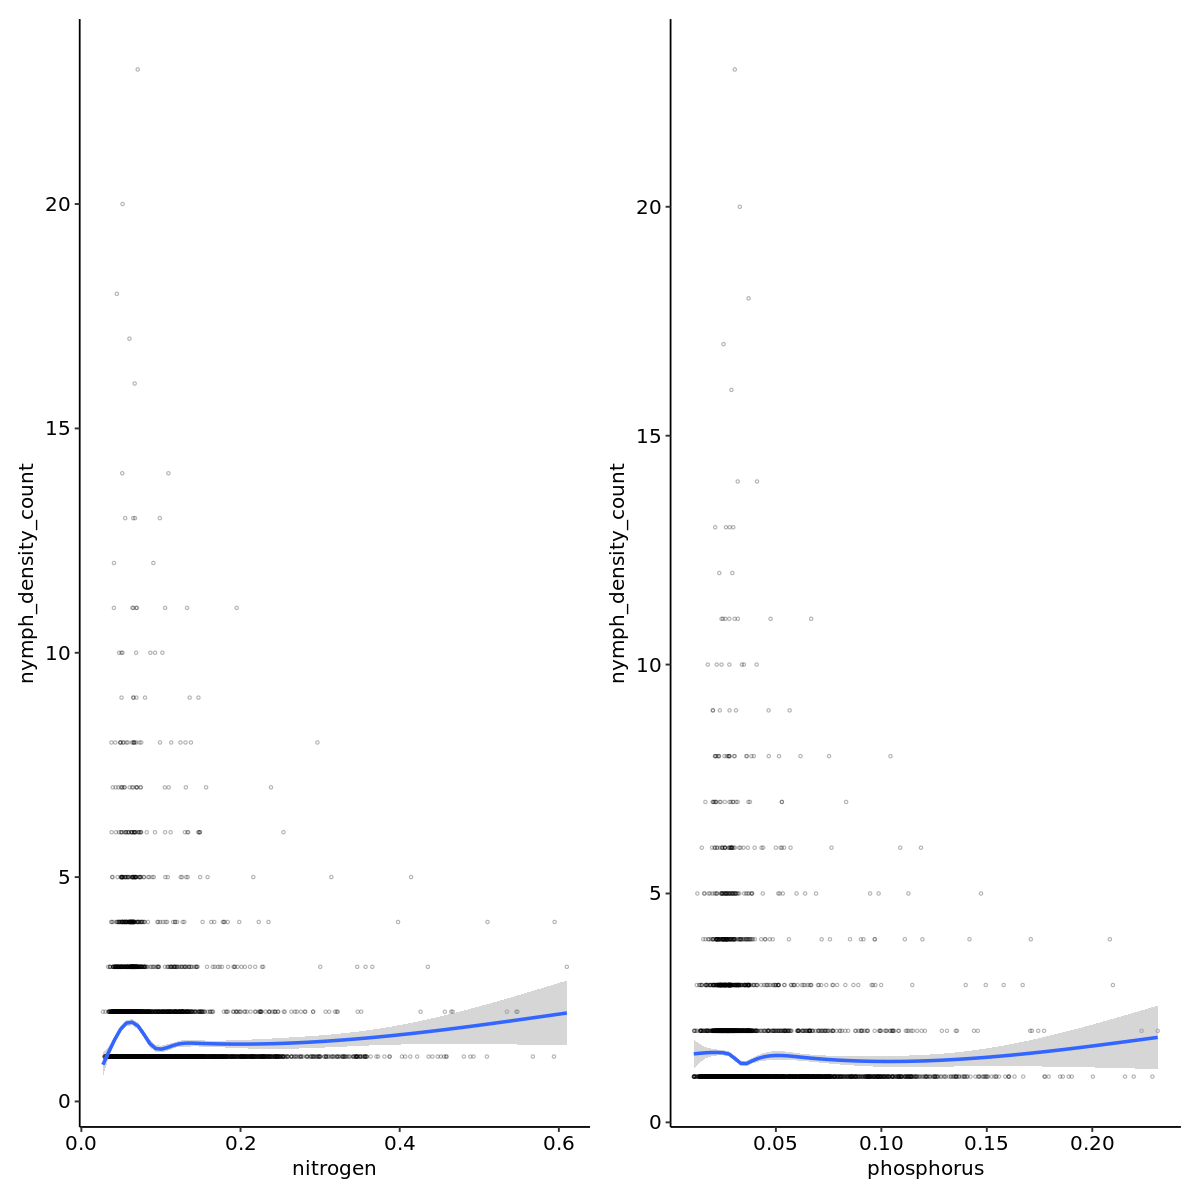

In [10]:
nto_plot <- outbreak_data |>
    ggplot(aes(x=nitrogen,y=nymph_density_count)) +
        geom_point(pch=21,alpha=0.3,size=0.6) +
        geom_smooth() +
        theme_pubr()

pto_plot <- outbreak_data |>
    ggplot(aes(x=phosphorus,y=nymph_density_count)) +
        geom_point(pch=21,alpha=0.3,size=0.6) +
        geom_smooth() +
        theme_pubr()

nto_plot + pto_plot

## Modeling

In [11]:
head(outbreak_data,1)


polygon_id,longitude,latitude,nymph_density,nymph_density_count,nymph_density_total_count,nitrogen,phosphorus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
162921,137.1195,-33.36002,4,1,1,0.07035461,0.02197414


In [13]:
mod1 <- bam(nymph_density_count ~
               s(nitrogen,k=25) +
               s(phosphorus,k=25) +
               s(nymph_density_total_count,k=25) +
               te(longitude,latitude,bs=c('tp','tp'),k=25),
           select = TRUE,
           discrete = TRUE,
           nthreads = 20,
          family = tw(),
          data = outbreak_data)

mod2 <- bam(nymph_density_count ~
               s(nitrogen,k=25) +
               s(phosphorus,k=25),
           select = TRUE,
           discrete = TRUE,
           nthreads = 20,
          family = tw(),
          data = outbreak_data)

mod3 <- bam(nymph_density_count ~
               s(nymph_density_total_count,k=25) +
               te(longitude,latitude,bs=c('tp','tp'),k=25),
           select = TRUE,
           discrete = TRUE,
           nthreads = 20,
          family = tw(),
          data = outbreak_data)

mod4 <- bam(nymph_density_count ~ 1,
          family = tw(),
          data = outbreak_data)


Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”
Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”
Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”
Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”
Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”
Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”
Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”
Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”


ERROR: Error in data[[txt]]: subscript out of bounds


In [ ]:
# Combine the lists into a single list
models <- list('mod1'= mod1, 'mod2' = mod2, 'mod3'= mod3, 'mod4'= mod4)

# Save the combined list to an RDS file
saveRDS(models, here("output/spatial_modeling/model_objects/locust_outbreak_models.rds"))

In [105]:
k.check(mod)

,k',edf,k-index,p-value
s(nitrogen),24,6.876001,1.0060433,0.7000
s(phosphorus),24,6.464667,1.0153661,0.8375
s(nymph_density_total_count),24,23.572338,1.0119592,0.7900
"te(longitude,latitude)",224,48.905909,0.8992926,0.0000


# section 3: nil-observatiom modeling

In [ ]:
nill_data <- read_csv(here('data/processed/spatial_modeling/spatial_modeling_locust_nill_model_data.csv'),
                          show_col_types = FALSE)

In [ ]:
mod1 <- bam(nymph_density_count ~
               s(nitrogen,k=25) +
               s(phosphorus,k=25) +
               s(nymph_density_total_count,k=25) +
               te(longitude,latitude,bs=c('tp','tp'),k=25),
           select = TRUE,
           discrete = TRUE,
           nthreads = 20,
          family = tw(),
          data = nill_data)

mod2 <- bam(nymph_density_count ~
               s(nitrogen,k=25) +
               s(phosphorus,k=25),
           select = TRUE,
           discrete = TRUE,
           nthreads = 20,
          family = tw(),
          data = nill_data)

mod3 <- bam(nymph_density_count ~
               s(nymph_density_total_count,k=25) +
               te(longitude,latitude,bs=c('tp','tp'),k=25),
           select = TRUE,
           discrete = TRUE,
           nthreads = 20,
          family = tw(),
          data = nill_data)

mod4 <- bam(nymph_density_count ~ 1,
          family = tw(),
          data = nill_data)


In [ ]:
# Combine the lists into a single list
models <- list('mod1'= mod1, 'mod2' = mod2, 'mod3'= mod3, 'mod4'= mod4)

# Save the combined list to an RDS file
saveRDS(models, here("output/spatial_modeling/model_objects/locust_nil_models.rds"))